<a href="https://colab.research.google.com/github/vigneshK0404/NOva_Fitter_CNF/blob/main/CNF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install torchinfo
!pip install nflows

In [2]:
import torch
import torchinfo
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import tqdm
from torch.utils.data import DataLoader
import time

In [3]:
from nflows.flows.base import Flow  # a container for full Flow
from nflows.distributions.normal import StandardNormal  # Gaussian latent space distribution
from nflows.transforms.base import (
    CompositeTransform,
)  # a wrapper to stack simpler transformations to form a more complex one
from nflows.transforms.autoregressive import (
    MaskedAffineAutoregressiveTransform,
)  # the basic transformation, which we will stack several times
from nflows.transforms.autoregressive import (
    MaskedPiecewiseRationalQuadraticAutoregressiveTransform,
)  # the basic transformation, which we will stack several times
from nflows.transforms.permutations import ReversePermutation # a layer that simply reverts the order of outputs

In [4]:
print(torch.cuda.is_available())
print(torch.cuda.device_count())
dnumber = 0
device = torch.device(f"cuda:{dnumber}" if torch.cuda.is_available() else "cpu")
print(device)
device_name = torch.cuda.get_device_name(dnumber)
print(device_name)

True
1
cuda:0
NVIDIA A100-SXM4-80GB


In [87]:
def gauss(N,mu,sig,x):
    N_t = N.reshape(-1,1)
    mu_t = mu.reshape(-1,1)
    sig_t = sig.reshape(-1,1)

    term1 = N_t / (sig_t * np.sqrt(2 * np.pi))
    term2 = np.exp(-0.5 * np.square((x - mu_t) / sig_t))
    return np.array(term1 * term2)


def generatePrior(sampleSize):
    N1 = np.random.uniform(10,50,sampleSize)
    N2 = np.random.uniform(10,30,sampleSize)

    mu1 = np.random.uniform(1,3,sampleSize)
    mu2 = np.random.uniform(5,9,sampleSize)

    sig1 = np.random.uniform(1,3,sampleSize)
    sig2 = np.random.uniform(5,9,sampleSize)

    return N1,mu1,sig1,N2,mu2,sig2


def generateTrainingData(sampleNumber):
  N1,mu1,sig1,N2,mu2,sig2 = generatePrior(sampleNumber)

  raw = np.arange(0.5,10,1) #startbinCenter, endBinEdge, StepSize [0.5,1.5...9.5]
  gaussTotal = gauss(N1,mu1,sig1,raw) + gauss(N2,mu2,sig2,raw)

  binNumber = len(gaussTotal)
  dataPoisson = np.random.poisson(lam=gaussTotal,size=None)

  thetaData = np.column_stack((N1,mu1,sig1,N2,mu2,sig2))
  return dataPoisson, thetaData

dataPoisson, thetaData = generateTrainingData(10000000)

I am going to normalize the data using min-max I can preserve the relationships while keeping it ideal for sigmoid to take part perhaps. I also found appraches involving log, if this does not work I will look into that.

In [88]:
print(dataPoisson.shape, thetaData.shape)
max_vals = torch.tensor(np.max(dataPoisson, axis = 0))
min_vals = torch.tensor(np.min(dataPoisson, axis = 0))
input_p = torch.tensor(dataPoisson,dtype=torch.float32)

(10000000, 10) (10000000, 6)


We may have to rethink structure of data storage for CNF later. But for now the autoencoder simply needs to take the 10-D output in and minimize loss.

In [89]:
from torch.nn.modules.activation import Softmax
from nflows.transforms.nonlinearities import Sigmoid
class autoEncoder(torch.nn.Module):
  def __init__(self, input_dim, hidden_dim,min_data,max_data):
    super().__init__()

    #self.max = torch.nn.Parameter(max_vals,requires_grad=False)
    #self.min = torch.nn.Parameter(min_vals,requires_grad=False)

    self.register_buffer("min", min_data)
    self.register_buffer("max", max_data)



    self.encoder = torch.nn.Sequential(
        torch.nn.Linear(input_dim,32),
        torch.nn.ReLU(),
        torch.nn.Linear(32,hidden_dim),
    )

    self.decoder = torch.nn.Sequential(
        torch.nn.Linear(hidden_dim,32),
        torch.nn.ReLU(),
        torch.nn.Linear(32,input_dim),
        torch.nn.Sigmoid()
    )

  def encode(self,x):
    x = (x-self.min)/(self.max - self.min + 1e-8)
    return self.encoder(x)

  def decode(self,x):
    dData = self.decoder(x)
    return dData*(self.max - self.min) + self.min

  def forward(self,x):
    eData = self.encode(x)
    dData = self.decode(eData)
    return dData

In [90]:
class CNF():
  def __init__(self,n_features, context_features,n_layers):

    base_dist = StandardNormal(shape=[n_features])
    transforms = []

    for i in range(n_layers):
      transforms.append(MaskedAffineAutoregressiveTransform(features=n_features, hidden_features=16, context_features=6)) #we are conditioning on 6 column data Ni,MUi and Stdi i{1,2}
      transforms.append(ReversePermutation(features=n_features))

    transform = CompositeTransform(transforms)
    self.flow = Flow(transform,base_dist)




In [106]:
input_dim = 10
n_features = 6 #doubles as hidden_dim
contextF = 6 #N1,N2,mu1,mu2,sig1,sig2
n_layers = 10

encodeModel = autoEncoder(input_dim,n_features,min_data=min_vals,max_data=max_vals).to(device)
CNFModel = CNF(n_features,context_features= contextF,n_layers=10).flow.to(device)

optimizer = torch.optim.Adam([
    {"params": CNFModel.parameters(), "lr": 1e-3},
    {"params": encodeModel.parameters(), "lr": 1e-4},
])


print(torchinfo.summary(encodeModel))
print(torchinfo.summary(CNFModel))

rloss = torch.nn.MSELoss()


Layer (type:depth-idx)                   Param #
autoEncoder                              --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       352
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       198
├─Sequential: 1-2                        --
│    └─Linear: 2-4                       224
│    └─ReLU: 2-5                         --
│    └─Linear: 2-6                       330
│    └─Sigmoid: 2-7                      --
Total params: 1,104
Trainable params: 1,104
Non-trainable params: 0
Layer (type:depth-idx)                                       Param #
Flow                                                         --
├─CompositeTransform: 1-1                                    --
│    └─ModuleList: 2-1                                       --
│    │    └─MaskedAffineAutoregressiveTransform: 3-1         1,740
│    │    └─ReversePermutation: 3-2                          --
│    │    └─MaskedAffineAutoregressiveTransform

In [101]:
print(dataPoisson)
print(thetaData)

[[11 10 10 ...  2  1  0]
 [ 4  3  5 ...  0  1  3]
 [ 6  9 12 ...  1  3  0]
 ...
 [ 7 16 19 ...  0  0  0]
 [ 3 10  4 ...  2  1  1]
 [ 7  9 10 ...  1  3  1]]
[[45.01745282  1.41469441  2.0862398  29.5002074   7.47866864  8.99300683]
 [12.44000459  2.05576858  1.23526295 15.22081674  5.04370838  8.78744719]
 [29.1063238   2.00803221  1.8173286  26.32470933  6.64613421  5.95373273]
 ...
 [46.63836662  2.44810769  1.31004389 13.88936506  5.09940481  6.22175614]
 [13.34110359  1.28312925  1.0680373  23.71922159  8.2616054   6.23433039]
 [37.93271685  2.77425186  2.07741767 25.39366787  5.24616113  5.02987587]]


100%|██████████| 5/5 [06:03<00:00, 72.64s/it]


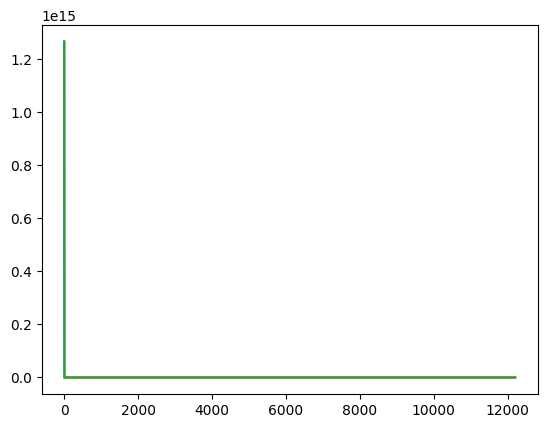

In [107]:
batch_size = 4096
num_iter = 5 #reduce number of iterations this converges a lot quicker

max_batch = int(dataPoisson.shape[0] / batch_size)

logLoss = []
reconLoss = []

for i in tqdm.tqdm(range(num_iter)):
  permut = np.random.permutation(dataPoisson.shape[0])
  dataPoisson_shufle = dataPoisson[permut]
  thetaData_shuffle = thetaData[permut]

  for i_batch in range(max_batch):
    start = i_batch * batch_size
    end = start + batch_size

    pData = torch.tensor(dataPoisson_shufle[start:end], device = device).float()
    tData = torch.tensor(thetaData_shuffle[start:end], device = device).float()

    #print(pData,tData)

    pData_encoded = encodeModel.encode(pData)

    optimizer.zero_grad()

    nll = -CNFModel.log_prob(pData_encoded, context=tData)

    pData_decoded = encodeModel.decode(pData_encoded)
    recon_loss = rloss(pData_decoded,pData)
    cnf_loss = nll.mean()

    loss = cnf_loss + recon_loss

    logLoss.append(cnf_loss.item())
    reconLoss.append(recon_loss.item())

    #print(f"nll:{cnf_loss}")
    #print(f"recon_loss:{recon_loss}")
    #print(f"total Loss:{loss}")

    loss.backward()
    optimizer.step()




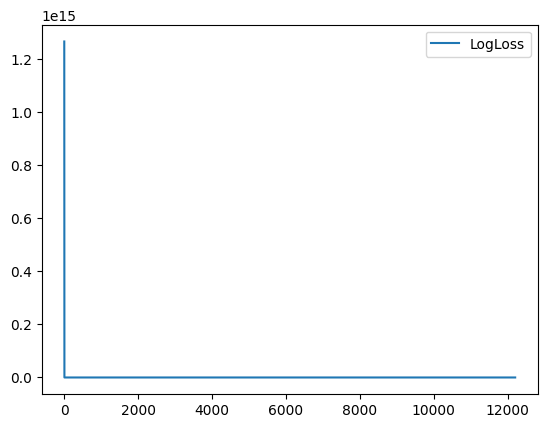

-17.38094711303711 5.521969795227051 -11.858977317810059
-0.3177024680712094


In [113]:
totalLoss = np.array(logLoss) + np.array(reconLoss)
plt.plot(logLoss,label="LogLoss")
#plt.plot(reconLoss,label="reconLoss")
#plt.plot(totalLoss, label="totalLoss")
plt.legend()
plt.show()

print(logLoss[-1], reconLoss[-1],totalLoss[-1])
print(reconLoss[-1]/logLoss[-1])

In [83]:
plr = 1e-4
inputDim = 10
hiddenDim = 6
compress = autoEncoder(inputDim, hiddenDim,min_data=min_vals, max_data=max_vals).to(device)
optim = torch.optim.Adam(compress.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()
torchinfo.summary(compress)

Layer (type:depth-idx)                   Param #
autoEncoder                              --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       352
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       198
├─Sequential: 1-2                        --
│    └─Linear: 2-4                       224
│    └─ReLU: 2-5                         --
│    └─Linear: 2-6                       330
│    └─Sigmoid: 2-7                      --
Total params: 1,104
Trainable params: 1,104
Non-trainable params: 0

100%|██████████| 6/6 [04:05<00:00, 40.86s/it]

6


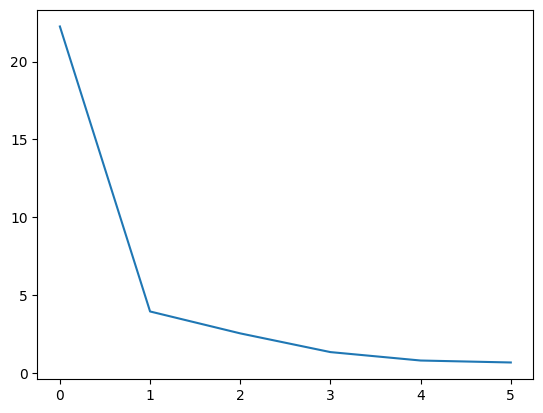

In [84]:
max_iter = 6
losses = []
Datasets = DataLoader(dataPoisson, batch_size = 4096, shuffle=True)

for iter in tqdm.tqdm(range(max_iter)):
  iter_losses = []
  for x_batch in Datasets:
      x_batch = x_batch.to(device, non_blocking=True).float()
      optim.zero_grad()
      y_pred = compress(x_batch)
      loss = loss_fn(y_pred, x_batch)
      iter_losses.append(loss.item())
      loss.backward()
      optim.step()

  losses.append(np.mean(np.array(iter_losses)))

print(len(losses))
plt.plot(losses)


In [85]:
print(losses[-1])

0.6869250672894556


[6.8845186 5.7850323 3.2121716 9.139879  6.909005  4.57957   2.8760924
 1.9813756 1.4724131 1.273568 ]
[7. 6. 3. 9. 7. 6. 1. 3. 1. 0.]


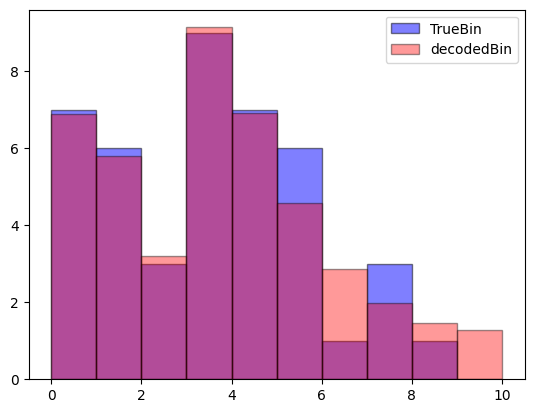

In [86]:
testP,_ = generateTrainingData(1)
testP = torch.tensor(testP, dtype = torch.float32)
testP = testP.to(device)
decodePtest = compress(testP).to("cpu").detach().numpy().flatten()
testP_CPU = testP.to("cpu").detach().numpy().flatten()

print(decodePtest)
print(testP_CPU)

bins = np.array(range(11))
plt.hist(bins[:-1], bins,weights=testP_CPU,color='blue',edgecolor='black',alpha=0.5,label="TrueBin")
plt.hist(bins[:-1], bins,weights=decodePtest,color='red',edgecolor='black',alpha=0.4,label="decodedBin")
plt.legend()